In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm
import pandas as pd


%config InlineBackend.figure_format = 'retina'

In [2]:
def mass_to_std_factor(mass=0.95):
    rv = norm(0.0, 1.0)
    std_factor = rv.ppf((1.0 + mass) / 2)
    return std_factor


def plot_mass_normal(mass=0.95, mean=0.0, scale=1.0):
    rv = norm(mean, scale)
    std_factor = mass_to_std_factor(mass)
    x = np.linspace(rv.ppf(1e-10), rv.ppf(1 - 1e-10), 500)
    y = rv.pdf(x)
    plt.plot(x, y)
    idx = np.where((x < mean + std_factor * scale) & (x > mean - std_factor * scale))[0]
    plt.fill_between(x[idx], y[idx], 0, color="k", alpha=0.2)
    plt.ylim((0, y.max() + 0.1))
    plt.title(f"Mass: {mass:0.2f}, std_factor:{std_factor:0.2f}")

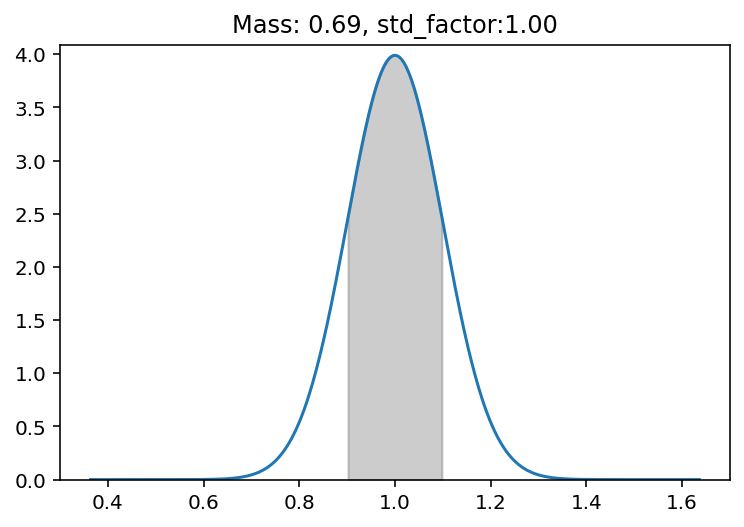

In [3]:
plot_mass_normal(mass=0.685, mean=1, scale=0.1)

### GP dataset

In [4]:
X = np.linspace(start=0, stop=10, num=200).reshape(-1, 1)
f = np.squeeze(X * np.sin(X))
y = f + 2 * np.random.randn(len(X))

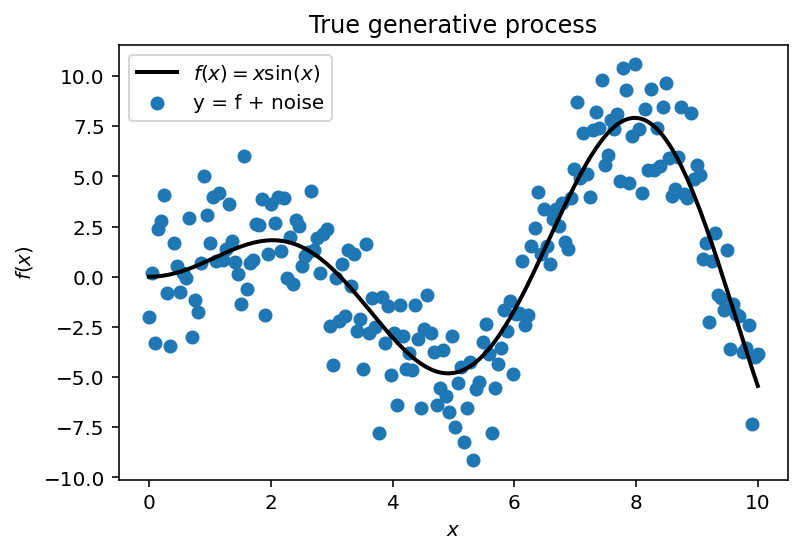

In [5]:
plt.plot(X, f, label=r"$f(x) = x \sin(x)$", lw = 2, color='k')
plt.scatter(X, y, label=r"y = f + noise")


plt.legend()
plt.xlabel("$x$")
plt.ylabel("$f(x)$")
_ = plt.title("True generative process")

In [6]:
rng = np.random.RandomState(1)
training_indices = rng.choice(np.arange(y.size), size=20, replace=False)
X_train, y_train = X[training_indices], y[training_indices]

calibration_indices = rng.choice(np.arange(y.size), size=30, replace=False)
X_cal, y_cal = X[calibration_indices], y[calibration_indices]

In [7]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF

kernel = 1 * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e2))
gaussian_process = GaussianProcessRegressor(
    kernel=kernel, n_restarts_optimizer=9, alpha=0.9
)

### Plotting reliability without model training

In [8]:
def plot_find_p(X, y, regressor, mass=0.95, plot=False):
    mean_prediction, std_prediction = regressor.predict(X, return_std=True)
    std_factor = mass_to_std_factor(mass)
    idx = np.where(
        (y.flatten() < mean_prediction + std_factor * std_prediction)
        & (y.flatten() > mean_prediction - std_factor * std_prediction)
    )[0]

    p_hat = len(idx) / len(X)

    if plot:

        plt.plot(X, y, label=r"$f(x) = x \sin(x)$", linestyle="dotted")
        plt.scatter(X_train, y_train, label="Observations", s=5)
        plt.plot(X, mean_prediction, label="Mean prediction")
        plt.fill_between(
            X.ravel(),
            mean_prediction - std_factor * std_prediction,
            mean_prediction + std_factor * std_prediction,
            alpha=0.2,
            label=rf"{100*mass}% CI, $\mu \pm {std_factor:0.2f}\sigma$",
        )

        plt.scatter(X[idx], y[idx], label="Within", color="C1")

        plt.legend(
            bbox_to_anchor=(1.04, 1),
            loc="upper left",
        )
        plt.xlabel("$x$")
        plt.ylabel("$f(x)$")
        plt.title(rf"p = {mass}, $\hat{{p}}$ = {p_hat:0.2f}")
    return (mass, p_hat)

(0.98, 0.37)

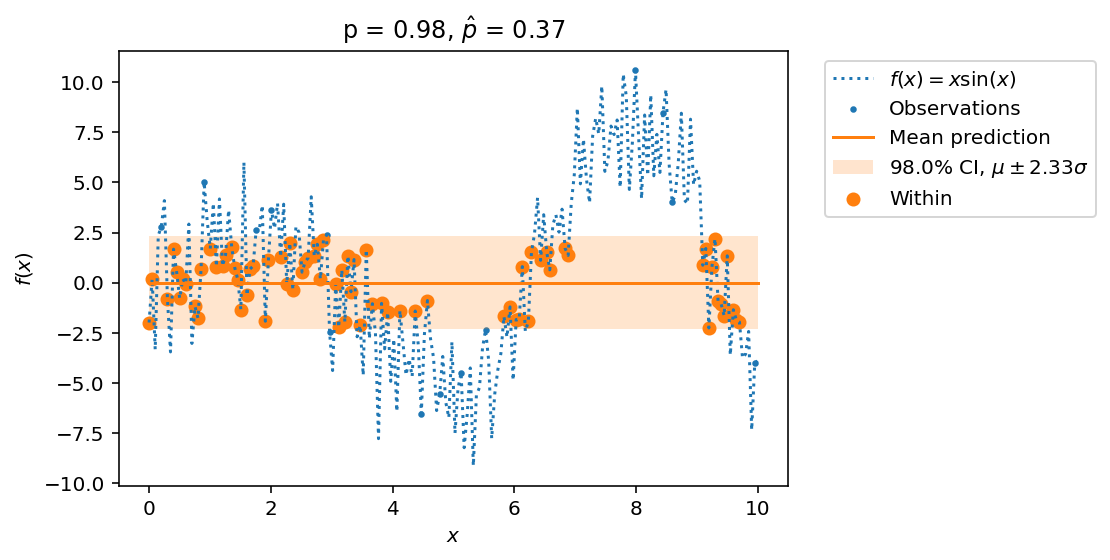

In [9]:
# vary this mass to understand better
plot_find_p(X, y, gaussian_process, mass=0.98, plot=True)

(0.9, 0.25)

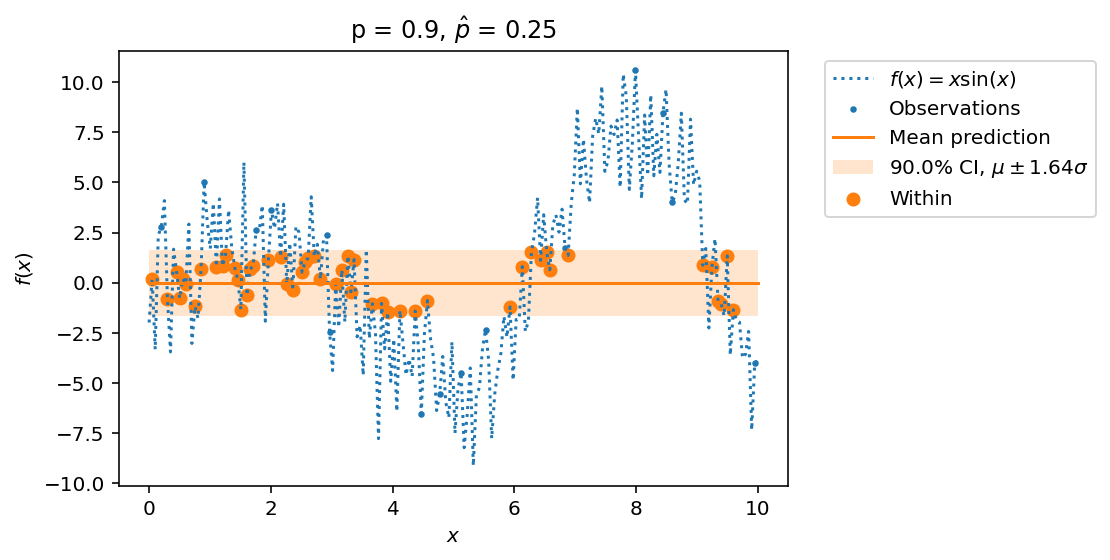

In [10]:
# vary this mass to understand better
plot_find_p(X, y, gaussian_process, mass=0.9, plot=True)

In [11]:
def plot_calibration(X_cal, y_cal, regressor, plot=False):
    mean_prediction, std_prediction = regressor.predict(X_cal, return_std=True)
    out = {}
    for mass in np.linspace(0.001, 0.999, 200):
        out[mass] = plot_find_p(X_cal, y_cal, regressor, mass)[1]
    df = pd.Series(out).to_frame()
    df.index.name = 'p'
    df.columns = ['p_hat']
    if plot:
        df.plot(legend=None, label=False)
        plt.plot([0, 1], [0, 1], label="Ideal")
        plt.legend()
        plt.gca().set_aspect("equal")
        plt.xlabel("p")
        plt.ylabel(r"$\hat{p}$")
    return df

,p_hat
p,
0.001000,0.000
0.006015,0.000
0.011030,0.000
0.016045,0.000
0.021060,0.000
...,...
0.978940,0.370
0.983955,0.385
0.988970,0.420


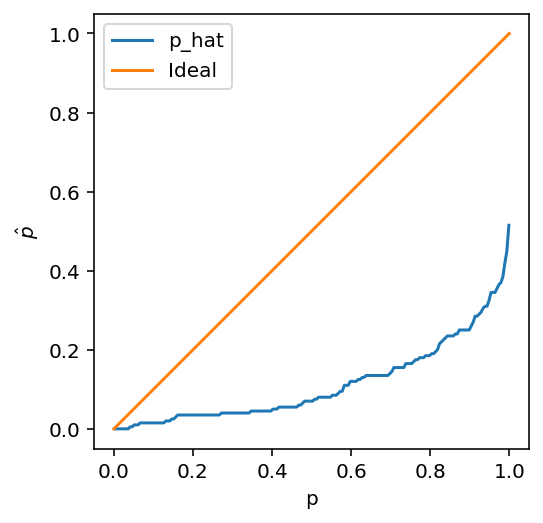

In [12]:
# Plotting the reliability plot for uncalibrated model
series = plot_calibration(X, y, gaussian_process, plot=True)
series

#### Calibrate untrained model on calibration dataset

In [13]:
from sklearn.isotonic import IsotonicRegression

series_cal = plot_calibration(X_cal, y_cal, gaussian_process)
calibrator = IsotonicRegression()

# Fit a model going from \hat{p} to p(true) (which is the line with 45 degree slope)
calibrator.fit(series_cal.values, series_cal.index)

IsotonicRegression()

#### Predict correct p on test dataset

In [14]:
series = plot_calibration(X, y, gaussian_process, plot=False)

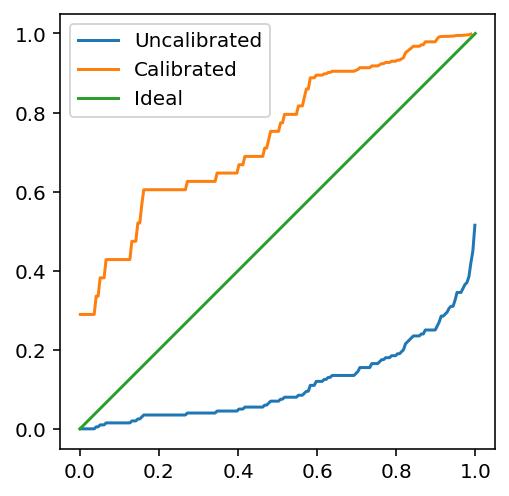

In [15]:
plt.plot(series.index, series.values, label='Uncalibrated')
plt.plot(series.index, calibrator.predict(series.values), label='Calibrated')

plt.plot([0, 1], [0, 1], label="Ideal")
plt.gca().set_aspect("equal")
plt.legend()

### Plotting reliability diagram post training

In [16]:
gaussian_process.fit(X_train, y_train)

GaussianProcessRegressor(alpha=0.9, kernel=1**2 * RBF(length_scale=1),
                         n_restarts_optimizer=9)

In [17]:
mean_prediction, std_prediction = gaussian_process.predict(X, return_std=True)

(0.9, 0.67)

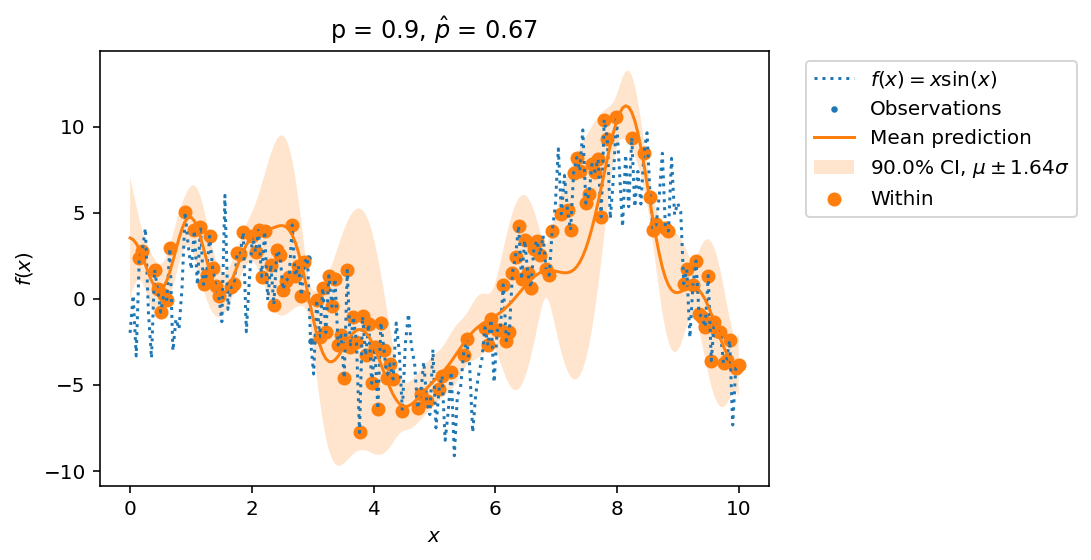

In [18]:
plot_find_p(X, y, gaussian_process, mass=0.9, plot=True)

,p_hat
p,
0.001000,0.000
0.006015,0.015
0.011030,0.015
0.016045,0.025
0.021060,0.040
...,...
0.978940,0.750
0.983955,0.765
0.988970,0.800


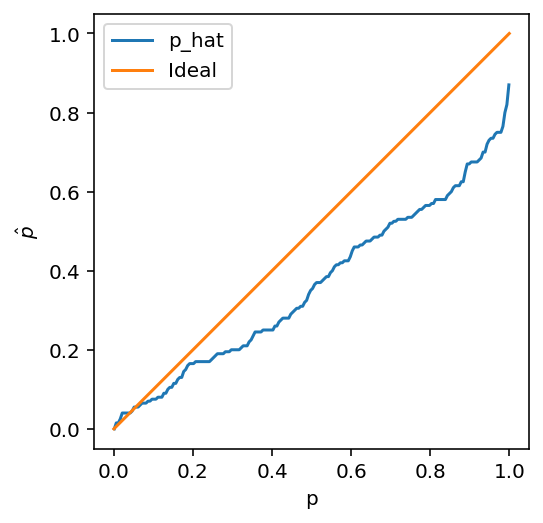

In [19]:
series = plot_calibration(X, y, gaussian_process, plot=True)
series

#### Calibrate trained model on calibration dataset

In [20]:
series_cal = plot_calibration(X_cal, y_cal, gaussian_process)
calibrator = IsotonicRegression()

# Fit a model going from \hat{p} to p(true) (which is the line with 45 degree slope)
calibrator.fit(series_cal.values, series_cal.index)

IsotonicRegression()

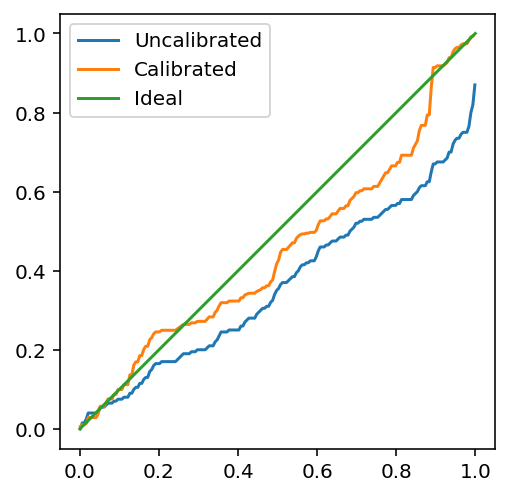

In [21]:
plt.plot(series.index, series.values, label='Uncalibrated')
plt.plot(series.index, calibrator.predict(series.values), label='Calibrated')

plt.plot([0, 1], [0, 1], label="Ideal")
plt.gca().set_aspect("equal")
plt.legend()